In [1]:
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import seaborn.objects as so

sns.set_palette("muted")
pd.set_option('display.max_colwidth', None)

In [2]:
def pp_hist_plot(df):
    plt.figure(figsize=(24,9))
    filt = list(set(df['pp_marker']))[0]
    cat_qw = list(set(df['cat_qw']))[0]
    x = sns.barplot(data = df, x = df['language'],y = df['percentage_kept'],
        hue='cat_qw')
    x.set(title="% Kept - {}".format(filt),
            xlabel='Language',
            ylabel='Percentage Kept')

In [3]:
a = !ls ./results/percent_kept

In [4]:
df_list = []
for csv in a:
    df_list.append(pd.read_csv('./results/percent_kept/'+csv))
complete = pd.concat(df_list)
print(len(complete))
complete.head()

249


,language,pp_threshold,pp_marker,cat_qw,percentage_kept
0,German,3865.084428,adult_pp_dict.pkl,False,0.580005
1,Estonian,5254.884523,adult_pp_dict.pkl,False,0.585816
2,Lithuanian,32722.905854,adult_pp_dict.pkl,False,0.575236
3,Romanian,3289.502074,adult_pp_dict.pkl,False,0.694013
4,Hungarian,13742.707307,adult_pp_dict.pkl,False,0.635060


In [5]:
complete = complete.drop_duplicates()

In [6]:
filter_map = {'adult_pp_dict.pkl':'mean adult pp',
 'pp_score_adult_oscar_filt_minus_std15.pkl':'mean adult pp std filter',
 'pp_score_adult_oscar_filt_minus_top5p.pkl': 'mean adult pp top5p',
 'ud_pp_dict.pkl':'mean UD pp'}

In [7]:
complete['pp_marker'] = complete['pp_marker'].map(filter_map)

## Plots

### Categories and Quality Warnings

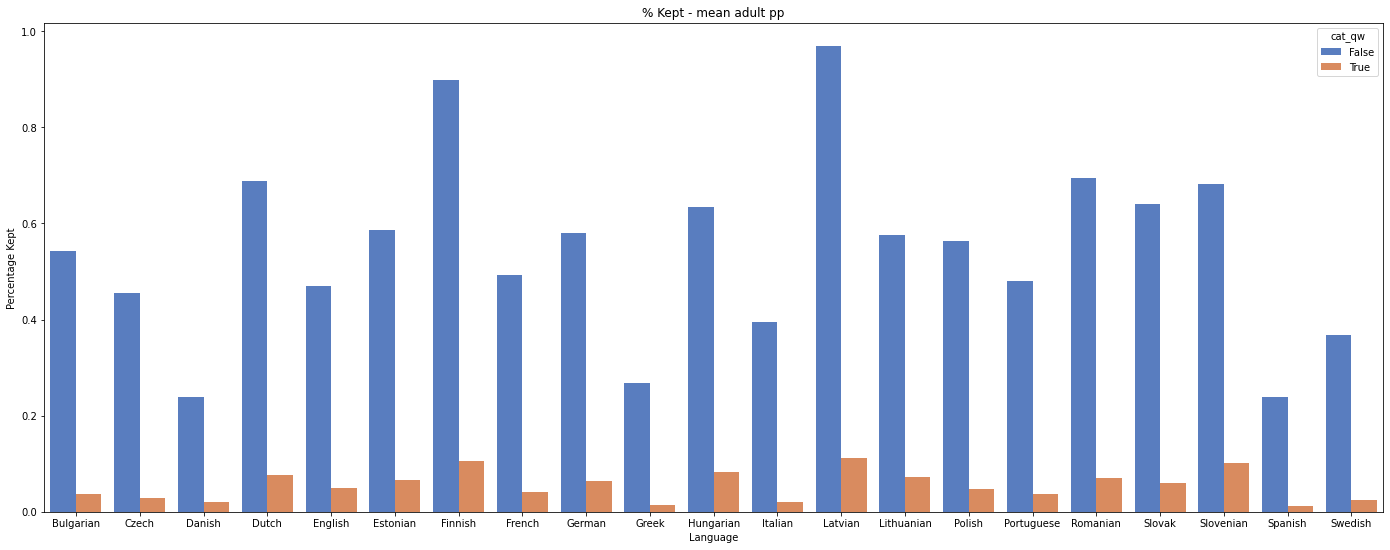

In [8]:
pp_hist_plot(complete[complete['pp_marker']=='mean adult pp'].sort_values(by='language'))

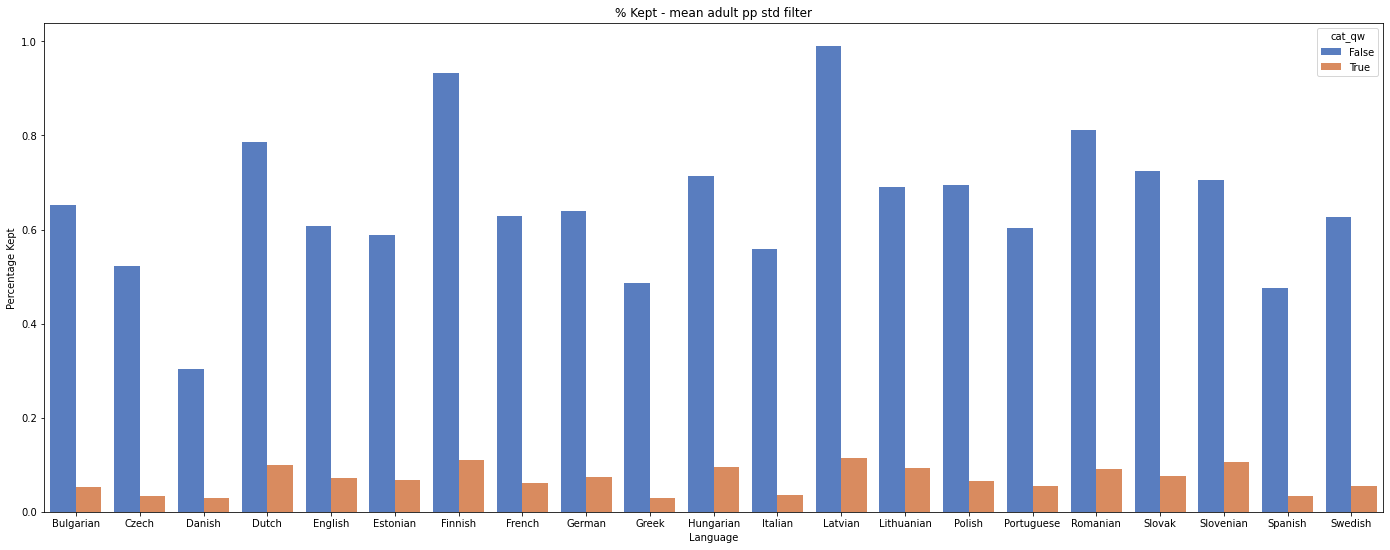

In [9]:
pp_hist_plot(complete[complete['pp_marker']=='mean adult pp std filter'].sort_values(by='language'))

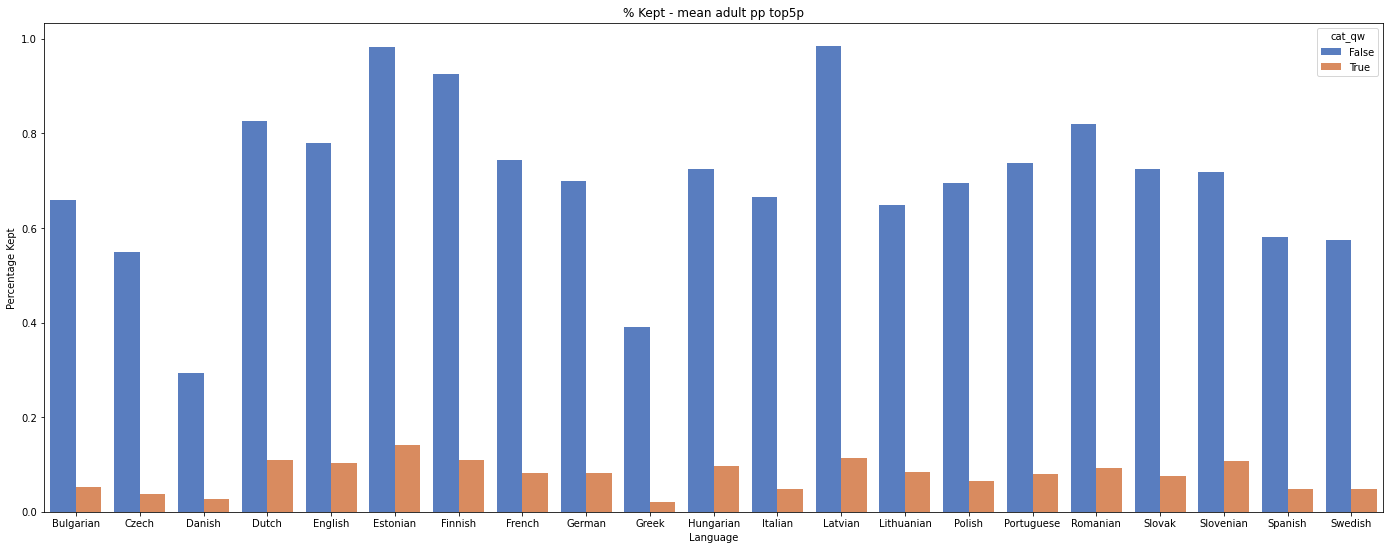

In [10]:
pp_hist_plot(complete[complete['pp_marker']=='mean adult pp top5p'].sort_values(by='language'))

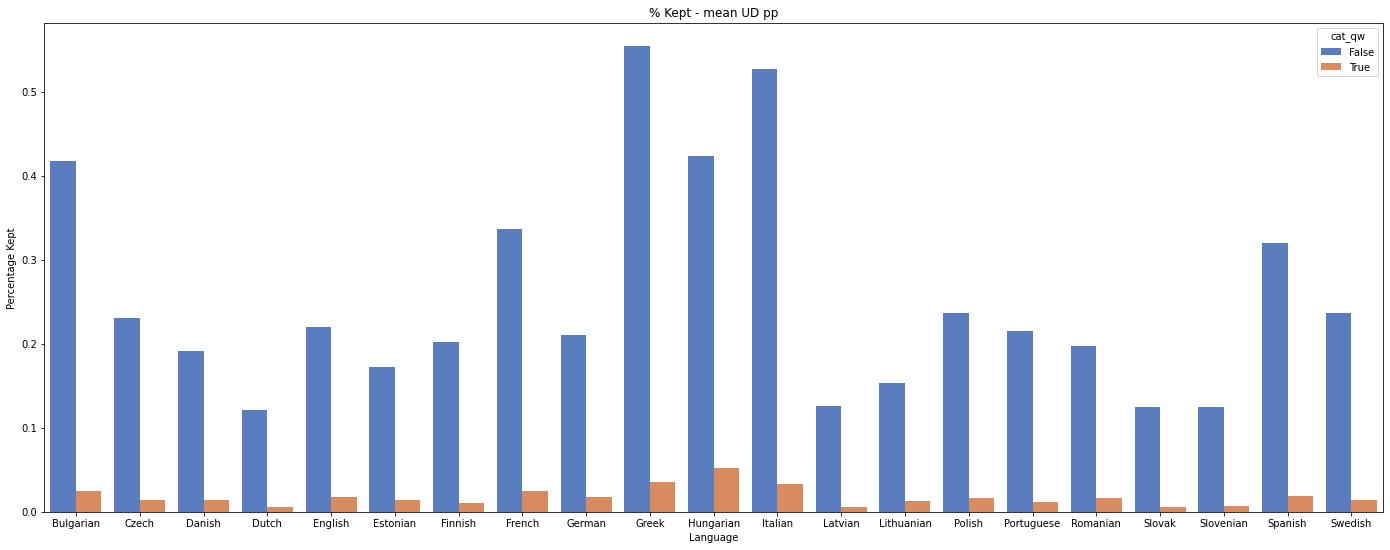

In [11]:
pp_hist_plot(complete[complete['pp_marker']=='mean UD pp'].sort_values(by='language'))

## Density Plot

<AxesSubplot:xlabel='total_bill', ylabel='Density'>

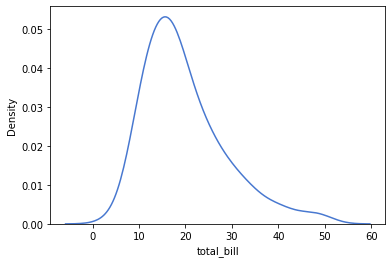

In [12]:
tips = sns.load_dataset("tips")
sns.kdeplot( x=tips["total_bill"])

In [30]:
import pickle, json, logging, msgspec

import zstandard as zstd
import polars as pl
import plotly.figure_factory as ff
import plotly.graph_objects as go

from typing import Set, Union

from utils.Utils import lg_paths, lang_dict, return_pp

from msgspec import DecodeError


class Metadata(msgspec.Struct):
    harmful_pp : Union[float, None] = None
    quality_warnings: Union[Set[str], None] = None
    categories : Union[Set[str], None] = None

class Oscar(msgspec.Struct):
    metadata: Metadata

logging.basicConfig(level=logging.DEBUG,filename=os.path.abspath('./')+'pp_filter_plots.log')

def adult_pp_generator(path):
    with open(path,'r') as f:
        for line in f.readlines():
            if line.endswith('\n'):
                line = line.rsplit('\n',1)[0]
            doc = msgspec.json.decode(line, type=Oscar)
            yield doc.metadata.harmful_pp

In [31]:
with open ('./results/pp_mean_dicts/ud_pp_dict.pkl', 'rb') as f:
    ud_pp_thresholds = pickle.load(f)

with open ('./results/pp_mean_dicts/adult_pp_dict.pkl', 'rb') as f:
    adult_pp_thresholds = pickle.load(f)

In [32]:
adult_path_list=[]
for root,dirs,files in os.walk('./data/processed/adult-oscar'):
    for file in files:
        adult_path_list.append(os.path.join(root,file))

ud_path_list=[]
for root,dirs,files in os.walk('./results/pps'):
    for file in files:
        if file.endswith('lines.json'):
            ud_path_list.append(os.path.join(root,file))

In [39]:
def plot_pp(language):
    plt.figure(figsize=(24,9))
    lg = lang_dict[language]

    global adult_path_list
    global ud_path_list

    cur_adult_paths = []
    for path1 in adult_path_list:
        if os.path.basename(path1).startswith(lg):
            cur_adult_paths.append(path1) 
    
    cur_ud_paths = []
    for path in ud_path_list:
        if os.path.basename(path).startswith(lg):
            cur_ud_paths.append(path)

    # # ADULT CONTENT SCORES
    adult_oscar_scores = {'pp_score':[]}
    for file in cur_adult_paths:
        print(file)
        with open(file,'r') as f:
            for line in f.readlines():
                if line:
                    try:                   #                     document = msgspec.json.decode(line, type=Oscar)
                        doc = msgspec.json.decode(line,type=Oscar)
                    except DecodeError:
                        logging.info(line)
                adult_oscar_scores['pp_score'].append(doc.metadata.harmful_pp)
        try:
            dataframe = pl.read_ndjson(file)
            # print(dataframe.head())
            # Gets the perplexity of each document as a list
            adult_oscar_scores['pp_score'].extend(list(map(return_pp, dataframe[:,2])))
        except RuntimeError as r:
            # Runtime errors are raised when the read_ndjson method cannot read it
            # completely (most likely requires a re run of the create_adul_ds.py for
            # this specific language)
            logging.warning("{}:\n{}".format(r ,path))
            continue
        except KeyError as k:
            logging.warning("{}:{}".format(k ,path))
            continue

    #
    ud = pd.concat([pd.read_json(p,lines=True) for p in cur_ud_paths])
    ud = ud[ud.line_score < ud.line_score.quantile(.95)]
    # print(len(ud))

    # # Seaborn
    # a = sns.kdeplot(data=adult_oscar_scores, x="pp_score", color='blue')
    # b = sns.kdeplot(data=ud, x="line_score", color='orange')
    
    # #
    # a.axvline(ud_pp_thresholds[language], ymax=0.5,label='ud',color='red')
    # b.axvline(adult_pp_thresholds[language], ymax=0.3, label='adult',color='green')
    
    #
    # Plotly
    group_labels = ['Oscar','UD']
    fig = ff.create_distplot([adult_oscar_scores['pp_score'],ud['line_score']],group_labels=group_labels,
     show_hist=False, show_curve=True,show_rug=False)

    # fig.add_trace(go.Scatter(x=[ud_pp_thresholds[language],ud_pp_thresholds[language]], 
    #                      y=[0,1], 
    #                      mode='lines', 
    #                      line=dict(color='green', width=2, dash='dash'),
    #                      name='ud mean perplexity'))
    fig.update_layout(title=language)

    #
    # plt.legend()
    # plt.title(language)
    # plt.xscale('log',base=10) 
    fig.add_vline(x=ud_pp_thresholds[language], line_width=2, line_dash="dash", line_color="orange")
    fig.add_vline(x=adult_pp_thresholds[language], line_width=2, line_dash="dash", line_color="dark blue")
    fig.show()

In [40]:
i = 0
for language in ud_pp_thresholds.keys():
    plot_pp(language)
    i+=1
    if i==3:
        break

./data/processed/adult-oscar/bg_meta/bg_meta.jsonl


./data/processed/adult-oscar/cs_meta/cs_meta_part_1.jsonl
./data/processed/adult-oscar/cs_meta/cs_meta_part_2.jsonl


./data/processed/adult-oscar/da_meta/da_meta.jsonl


<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

In [ ]:
for lang in ud_pp_thresholds.keys():
    print(lang)
    lg = lang_dict[lang]

    cur_ud_paths = []
    for path in ud_path_list:
        if os.path.basename(path).startswith(lg):
            cur_ud_paths.append(path)
            
    ud = pd.concat([pd.read_json(p,lines=True) for p in cur_ud_paths])
    print(ud.sort_values('line_score',ascending=False)['doc_lines'][:5])
    


Bulgarian
593           халка. \n
410     възможности? \n
6800       приемник. \n
1597         чекове. \n
586     музикален... \n
Name: doc_lines, dtype: object
Czech
8616        Pokroky \n
2098        zmlkli. \n
2046        paruku. \n
6841      prospěla. \n
9549    gratuluji." \n
Name: doc_lines, dtype: object
Danish
6180                                                                        dommen. \n
710                                              Philipsen, Hasselvej 6, 3790 Hasle \n
5151            informationsviden skab) 9,7 Humaniora II (dramaturgi, kunsthistorie,\n
942     forårsaget overvægten. Ulrik Sørensen økonomidirektør Danbyg Totalentreprise\n
5152             litteraturhisto rie, etnografi, filosofi, idéhistorie) 9,6 Jura 9,6\n
Name: doc_lines, dtype: object
Dutch
12375                           achthondernegenenvijftigduizendvierhonderddrieëndertigste\n
10088              golfbanen, tennisbanen, kabeltreintjes, beeldenparken, openluchtmusea,\n
10086       wandelplants